Description: implementation required by Questions 1 & 2 of Coursework 4

Version: 1.1.4.20210709

Author: Jichen Zhao

# Preparation

## Importing modules

**NOTE:**

1. The following code needs uncommenting if the `stopwords` from `nltk` is not downloaded or up-to-date.

In [1]:
# import nltk

# nltk.download('stopwords')

2. Please uncomment the following code if it has not been done/updated for `spacy`. `python` may need to be replaced with `python3` depending on the environment.

In [2]:
# !python -m spacy download en_core_web_sm

In [3]:
from collections import Counter
import os
import re
import warnings

from gensim.models import CoherenceModel, Phrases, TfidfModel
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
import gensim.corpora as gs_corpora
import gensim.matutils as gs_matutils
import gensim.utils as gs_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns
import spacy

warnings.filterwarnings('ignore', category = DeprecationWarning)  # Ignore unnecessary deprecation warnings.
models_dirname = 'Models'  # The directory name of the folder preserving running data.

if not os.path.isdir(models_dirname):
    os.makedirs(models_dirname)

C:\Users\zjcar\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Loading data

In [4]:
id_col = 'ID'
text_col = 'Text'

data = pd.read_csv('tweets.csv')
data.rename(columns = {'_id': id_col, 'text': text_col}, inplace = True)
data

,ID,Text
0,1409477134209458181,My son and I went on a tour to the Allianz Are...
1,1409477134691835908,@Veronic35709033 @SFODan @SimonCalder @grantsh...
2,1409477135228719105,(Ethereum looks to retake $2K days before Lond...
3,1409477135711064066,No Riley Dean in the squad either. Suggests an...
4,1409477137204191238,Highest ever temperatures in Canada - and US n...
...,...,...
53394,1409610186768142341,Will England be boycotting Qatar then where be...
53395,1409610187179180039,AHAHA NARR BC I WAS LIKE AYYYYY
53396,1409610187162411011,I’m in tears so many pogba haters were waiting...
53397,1409610187569303557,"Peter, top 5 countries: 1. Chad, 2. Taiwan, 3...."


## Pre-processing data

Although it is said that the dataset consists of reasonably good quality tweets, pre-processing is required to make it more suitable for topic modelling. One task would be removing redundant data.

In [5]:
data_unique = data.drop_duplicates(subset = [text_col])
data_unique.reset_index(drop = True, inplace = True)
data_unique

,ID,Text
0,1409477134209458181,My son and I went on a tour to the Allianz Are...
1,1409477134691835908,@Veronic35709033 @SFODan @SimonCalder @grantsh...
2,1409477135228719105,(Ethereum looks to retake $2K days before Lond...
3,1409477135711064066,No Riley Dean in the squad either. Suggests an...
4,1409477137204191238,Highest ever temperatures in Canada - and US n...
...,...,...
53226,1409610186768142341,Will England be boycotting Qatar then where be...
53227,1409610187179180039,AHAHA NARR BC I WAS LIKE AYYYYY
53228,1409610187162411011,I’m in tears so many pogba haters were waiting...
53229,1409610187569303557,"Peter, top 5 countries: 1. Chad, 2. Taiwan, 3...."


A procedure is implemented to preliminarily remove useless characters.

In [6]:
def clean(text: str) -> str:
    '''
    Clean up a tweet preliminarily.

    Parameters
    ----------
    text : the tweet text

    Returns
    -------
    text_clean : a list of words
    '''

    text = re.sub('\S*@\S*\s?', '', text)  # Remove emails.
    text = re.sub('@[A-Za-z]+[A-Za-z0-9-_]+', '', text)  # Remove mentions (@<username>).
    text = re.sub('http\S+', '', text)  # Remove weblinks.
    text = re.sub('\s+', ' ', text)  # Remove extra spaces and newline characters.
    text = re.sub('\'', '', text)  # Remove single quotes.
    text = gs_utils.simple_preprocess(text, deacc = True)  # Tokenise a tweet into a list of words, and remove some other unnecessary characters.
    return text

We could then build the bigram and trigram models using [`Phrases()`](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases) for further processing.

Adjectives, adverbs, nouns, and verbs are kept since they are part-of-speech (POS) tags contributing the most to the meaning of sentences. They would also be lemmatised to a normal form.

In [7]:
def reborn(data_clean: list) -> list:
    '''
    Remove stopwords, form bigrams and trigrams, and lemmatise data.
    Please note that this function could consume some time.

    Parameters
    ----------
    data_clean : the clean-up data

    Returns
    -------
    data_ready : the processed data
    '''

    bigram = Phrases(data_clean, threshold = 100)
    trigram = Phrases(bigram[data_clean], threshold = 100)
    bigram_trained = bigram.freeze()  # Freeze to gain better performance.
    trigram_trained = trigram.freeze()
    stopword_list = stopwords.words('english')
    stopword_list.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])  # Use the list to remove stopwords.
    data_ready = [[word for word in gs_utils.simple_preprocess(str(text)) if word not in stopword_list] for text in data_clean]
    data_ready = [bigram_trained[text] for text in data_ready]  # Form bigrams.
    data_ready = [trigram_trained[bigram_trained[text]] for text in data_ready]  # Form trigrams.

    # Keep POS tags.
    data_temp = []
    nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

    for text in data_ready:
        data_temp.append([token.lemma_ for token in nlp(' '.join(text)) if token.pos_ in ['ADJ', 'ADV', 'NOUN', 'VERB']])
        
    data_ready = [[word for word in gs_utils.simple_preprocess(str(text)) if word not in stopword_list] for text in data_temp]  # Remove stopwords once more after lemmatisation.
    data_ready = [text for text in data_ready if text]  # Remove empty processed tweets.
    print('The number of processed tweets kept:', len(data_ready))
    return data_ready

# Question 1

The solution in this part was inspired by [`the tutorial`](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models).

## Preparing for topic modelling

We would complete data-preprocessing tasks. A dictionary would be created using [`Dictionary()`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary), and the corpus would be generated with [`doc2bow()`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow).

**NOTE:** This step could consume some time.

In [8]:
data_clean_base = data_unique[text_col].apply(clean).tolist()  # Clean up tweets preliminarily.
print('The number of clean-up tweets kept:', len(data_clean_base))
data_ready_base = reborn(data_clean_base)
dict_base = gs_corpora.Dictionary(data_ready_base)  # Create a dictionary mapping from word IDs to words.
corpus_base = [dict_base.doc2bow(text) for text in data_ready_base]  # Create the corpus using the bag-of-words (BoW) format (term - frequency).

The number of clean-up tweets kept: 53231
The number of processed tweets kept: 52479


## Building an LDA topic model using [`LdaModel()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel)

The latent topics extracted would be printed using [`print_topics()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.print_topics).

**NOTE:** This step could consume some time if no data is preserved.

In [9]:
lda_base_filename = os.path.join(models_dirname, 'lda_base')

if os.path.isfile(lda_base_filename):
    lda_base = LdaModel.load(lda_base_filename)
else:
    lda_base = LdaModel(corpus = corpus_base, num_topics = 4, id2word = dict_base, chunksize = 1000, passes = 10, update_every = 1, iterations = 100, random_state = 100, per_word_topics = True)
    lda_base.save(lda_base_filename)

lda_base.print_topics()

[(0,
  '0.011*"play" + 0.011*"love" + 0.010*"time" + 0.010*"game" + 0.010*"watch" + 0.009*"euro" + 0.009*"loveisland" + 0.009*"tomorrow" + 0.009*"well" + 0.008*"team"'),
 (1,
  '0.017*"new" + 0.007*"amp" + 0.006*"free" + 0.006*"sign" + 0.006*"week" + 0.006*"today" + 0.006*"check" + 0.006*"fuck" + 0.005*"name" + 0.005*"join"'),
 (2,
  '0.008*"pay" + 0.007*"amp" + 0.005*"country" + 0.005*"help" + 0.005*"state" + 0.005*"people" + 0.005*"woman" + 0.004*"close" + 0.004*"year" + 0.004*"new"'),
 (3,
  '0.018*"people" + 0.014*"labour" + 0.008*"conservative" + 0.008*"tory" + 0.007*"give" + 0.006*"vote" + 0.005*"time" + 0.005*"amp" + 0.005*"well" + 0.005*"tell"')]

## Analysing results

We could attempt to identify each processed tweet's dominant topic, its percentage contribution, and keywords. The values of the first 10 tweets would be displayed in a table.

**NOTE:** This step could consume some time.

In [10]:
dominant_topics = pd.DataFrame()

# Get each processed tweet's main topic.
for _, row_list in enumerate(lda_base[corpus_base]):
    row = sorted(row_list[0] if lda_base.per_word_topics else row_list, key = lambda x: (x[1]), reverse = True)

    # Get each processed tweet's dominant topic, its percentage contribution, and keywords.
    for j, (topic_id, topic_prob) in enumerate(row):
        if j != 0:
            break

        word_prob = lda_base.show_topic(topic_id)  # Word-probability pairs for the dominant topic.
        topic_keywords = ', '.join([word for word, _ in word_prob])
        dominant_topics = dominant_topics.append(pd.Series([int(topic_id), round(topic_prob, 4), topic_keywords]), ignore_index = True)

dominant_topics = pd.concat([dominant_topics, pd.Series(data_ready_base)], axis = 1)
topic_id_col = 'Topic ID'
topic_prob_col = 'Percentage contribution'
topic_keywords_col = 'Keywords'
dominant_topics.columns = [topic_id_col, topic_prob_col, topic_keywords_col, text_col]
dominant_topics.head(10)

,Topic ID,Percentage contribution,Keywords,Text
0,3.0,0.5361,"people, labour, conservative, tory, give, vote...","[arena, admire, seat, arena, suddenly, point, ..."
1,3.0,0.6188,"people, labour, conservative, tory, give, vote...","[tell, tell, change, position]"
2,3.0,0.8553,"people, labour, conservative, tory, give, vote...","[look, retake_day, big_breakout, ahead, crypto..."
3,0.0,0.5888,"play, love, time, game, watch, euro, loveislan...","[suggest, half, back, partnership, thewli, sta..."
4,0.0,0.4149,"play, love, time, game, watch, euro, loveislan...","[high, ever, temperature, canada, north_w, lik..."
5,1.0,0.3635,"new, amp, free, sign, week, today, check, fuck...","[confirm, vaccine, work, ill, wait, find]"
6,3.0,0.8321,"people, labour, conservative, tory, give, vote...","[check, thread, reply, really, herd_immunity, ..."
7,3.0,0.8349,"people, labour, conservative, tory, give, vote...","[finding, exactly, back, choice, full, blow, t..."
8,0.0,0.8104,"play, love, time, game, watch, euro, loveislan...","[humble, tribute, narsimha]"
9,3.0,0.6207,"people, labour, conservative, tory, give, vote...","[case, wonder, crazy, people]"


Each topic's most representative processed tweet could then be found.

In [11]:
representative_text = pd.DataFrame()

for _, group in dominant_topics.groupby(topic_id_col):
    representative_text = pd.concat([representative_text, group.sort_values([topic_prob_col], ascending = False).head(1)])

representative_text.reset_index(drop = True, inplace = True)
representative_text

,Topic ID,Percentage contribution,Keywords,Text
0,0.0,0.9644,"play, love, time, game, watch, euro, loveislan...","[world, rival, sense, word, arsenal, football,..."
1,1.0,0.9580,"new, amp, free, sign, week, today, check, fuck...","[latest_vacancy, aa, career, recruit, new, hea..."
2,2.0,0.9495,"pay, amp, country, help, state, people, woman,...","[corporate, law, term, legal, support, busines..."
3,3.0,0.9651,"people, labour, conservative, tory, give, vote...","[drink, much, kool, aid, death, yesterday, day..."


Let us analyse the frequency distribution of the character length of processed tweets.

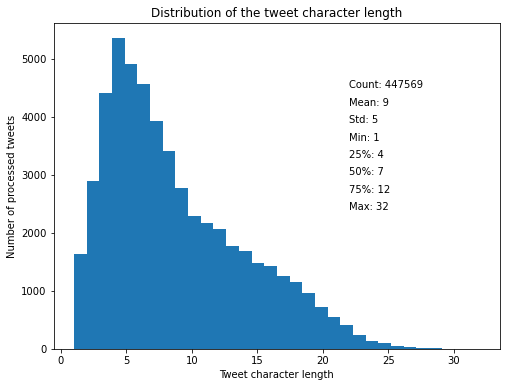

In [12]:
text_lens = [len(text) for text in dominant_topics[text_col]]
max_text_len = np.max(text_lens)
annotation_x = max_text_len - 10

# Draw a histogram indicating the distribution of the tweet character length.
plt.figure(figsize = (8, 6))
plt.hist(text_lens, bins = max_text_len)
plt.title('Distribution of the tweet character length')
plt.gca().set(xlabel = 'Tweet character length', ylabel = 'Number of processed tweets')
plt.text(annotation_x, 4500, 'Count: ' + str(np.sum(text_lens)))
plt.text(annotation_x, 4200, 'Mean: ' + str(round(np.mean(text_lens))))
plt.text(annotation_x, 3900, 'Std: ' + str(round(np.std(text_lens))))
plt.text(annotation_x, 3600, 'Min: ' + str(np.min(text_lens)))
plt.text(annotation_x, 3300, '25%: ' + str(round(np.quantile(text_lens, 0.25))))
plt.text(annotation_x, 3000, '50%: ' + str(round(np.median(text_lens))))
plt.text(annotation_x, 2700, '75%: ' + str(round(np.quantile(text_lens, 0.75))))
plt.text(annotation_x, 2400, 'Max: ' + str(max_text_len))
plt.show()

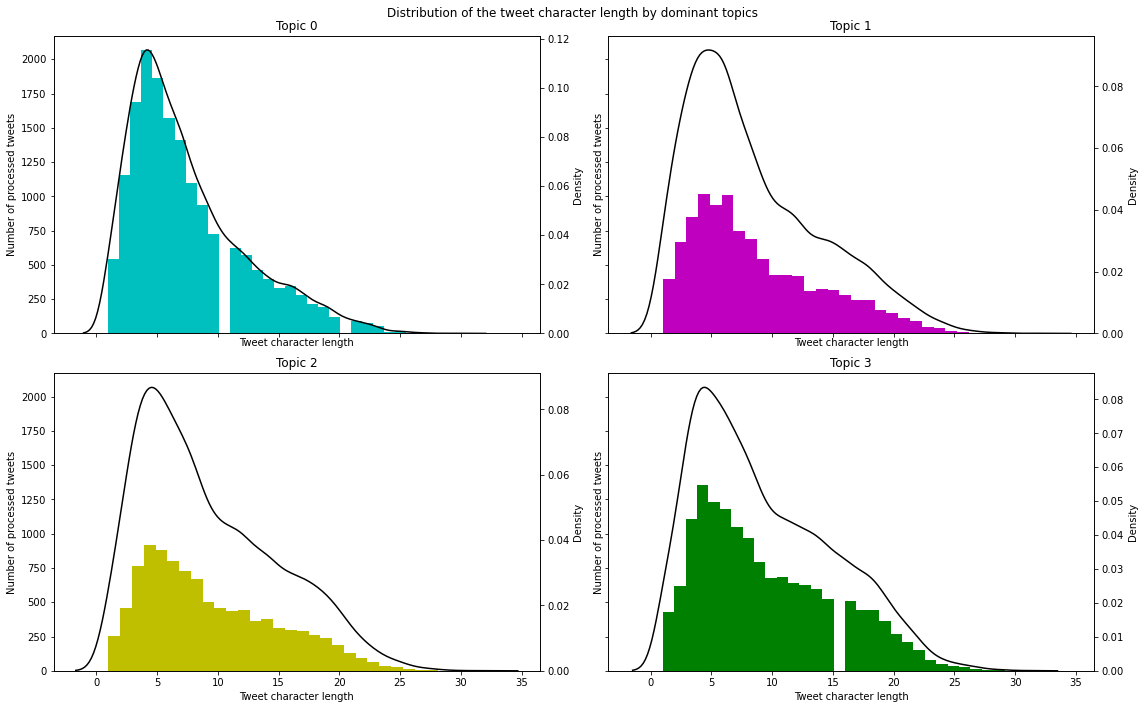

In [13]:
colours = ['c', 'm', 'y', 'g']
fig, axes = plt.subplots(2, 2, figsize = (16, 10), sharex = True, sharey = True)

# Draw a histogram and a density graph on the same subplot for each dominant topic.
for i, ax in enumerate(axes.flatten()):    
    dominant_topic_df = dominant_topics.loc[dominant_topics[topic_id_col] == i, :]
    ax_text_lens = [len(text) for text in dominant_topic_df[text_col]]
    ax.hist(ax_text_lens, bins = np.max(text_lens), color = colours[i])
    sns.kdeplot(ax_text_lens, color = 'k', shade = False, ax = ax.twinx())
    ax.set_title('Topic ' + str(i))
    ax.set_xlabel('Tweet character length')
    ax.set_ylabel('Number of processed tweets')
    
fig.tight_layout()
fig.subplots_adjust(top = 0.94)
fig.suptitle('Distribution of the tweet character length by dominant topics')
plt.show()

The keywords in the topics could also be observed by applying visualisation to the character length and importance of topic keywords.

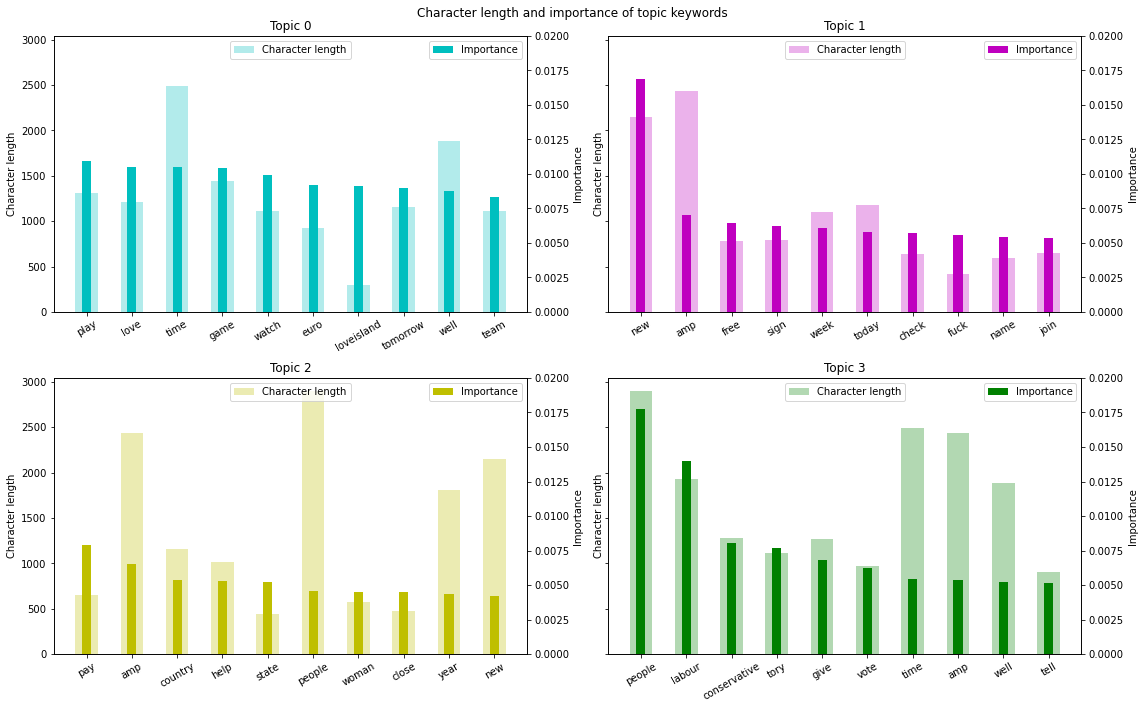

In [14]:
topics = lda_base.show_topics(formatted = False)
data_ready_base_flat = [word for words in data_ready_base for word in words]
counter = Counter(data_ready_base_flat)
word_importance = []

for i, topic in topics:
    for word, weight in topic:
        word_importance.append([word, i, weight, counter[word]])

word_col = 'Word'
importance_col = 'Importance'
length_col = 'Character length'
word_importance_df = pd.DataFrame(word_importance, columns = [word_col, topic_id_col, importance_col, length_col])
fig, axes = plt.subplots(2, 2, figsize = (16, 10), sharey = True)

for i, ax in enumerate(axes.flatten()):
    subplot_data = word_importance_df.loc[word_importance_df[topic_id_col] == i, :]
    subplot_words = subplot_data[word_col].tolist()
    ax.bar(x = subplot_words, height = subplot_data[length_col].tolist(), color = colours[i], width = 0.5, alpha = 0.3, label = length_col)
    ax_twin = ax.twinx()
    ax_twin.bar(x = subplot_words, height = subplot_data[importance_col].tolist(), color = colours[i], width = 0.2, label = importance_col)
    ax.set_title('Topic ' + str(i))
    ax.set_xticks(np.arange(len(subplot_words)))
    ax.set_xticklabels(word_importance_df.loc[word_importance_df[topic_id_col] == i, word_col], rotation = 30)
    ax.set_ylabel(length_col)
    ax_twin.set_ylabel(importance_col)
    ax_twin.set_ylim(0, 0.02)
    ax.legend(loc = 'upper center')
    ax_twin.legend(loc = 'upper right')

fig.tight_layout()
fig.subplots_adjust(top = 0.94)
fig.suptitle('Character length and importance of topic keywords')
plt.show()

pyLDAvis is a widely-used powerful visualisation tool for topic models. We could interact with the tool inside the notebook to investigate more info about the topic model.

In [15]:
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_base, corpus_base, dictionary = dict_base, n_jobs = 1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.187607 -0.024385       1        1  28.364616
0     -0.072762 -0.235429       2        1  26.533975
2     -0.054815  0.279985       3        1  22.885184
1      0.315184 -0.020171       4        1  22.216225, topic_info=        Term         Freq        Total Category  logprob  loglift
68    labour  1776.000000  1776.000000  Default  30.0000  30.0000
76    people  2722.000000  2722.000000  Default  29.0000  29.0000
576      new  2103.000000  2103.000000  Default  28.0000  28.0000
266     play  1302.000000  1302.000000  Default  27.0000  27.0000
440     love  1250.000000  1250.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
21      look   523.988849  1844.074591   Topic4  -5.2458   0.2461
170      job   366.747948   582.854676   Topic4  -5.6026   1.0411
1148    read   347.572780   636.697195   Topic4  -5.6563   0.8990
116     time   395.044254  2332.110406   Topic4  -5.5282  -0.2712
45      find   352.867444   952.225285   Topic4  -5.6411   0.5116

[221 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1475      2  0.997801  absolutely
1066      4  0.998694         add
323       1  0.998324         age
224       1  0.998280      almost
1702      4  0.997521     amazing
...     ...       ...         ...
1052      1  0.997885       write
795       1  0.996049       wrong
521       1  0.322145        year
521       2  0.414695        year
521       3  0.262818        year

[265 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

## Evaluating performance

The perplexity is computed based on the logarithm value from [`log_perplexity()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.log_perplexity). The coherence score is also calculated using [`CoherenceModel`](https://radimrehurek.com/gensim/models/coherencemodel.html#gensim.models.coherencemodel.CoherenceModel).

In [16]:
print('Perplexity:', np.exp(-1 * lda_base.log_perplexity(corpus_base)))
print('Coherence score:', CoherenceModel(model = lda_base, texts = data_ready_base, dictionary = dict_base).get_coherence())

Perplexity: 6855.397742131428
Coherence score: 0.2123404375709511


What if we increase the number of topics extracted? Let us build another LDA model with more extracted topics, visualise results using pyLDAvis, and evaluate the model's performance.

The latent topics extracted would be printed using [`print_topics()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.print_topics).

**NOTE:** This step could consume some time if no data is preserved.

In [17]:
lda_topic_filename = os.path.join(models_dirname, 'lda_topic')

if os.path.isfile(lda_topic_filename):
    lda_topic = LdaModel.load(lda_topic_filename)
else:
    lda_topic = LdaModel(corpus = corpus_base, num_topics = 10, id2word = dict_base, chunksize = 1000, passes = 10, update_every = 1, iterations = 100, random_state = 100, per_word_topics = True)
    lda_topic.save(lda_topic_filename)

lda_topic.print_topics()

[(0,
  '0.023*"euro" + 0.022*"loveisland" + 0.020*"win" + 0.020*"game" + 0.018*"tomorrow" + 0.016*"well" + 0.015*"great" + 0.015*"look" + 0.013*"man" + 0.011*"much"'),
 (1,
  '0.016*"city" + 0.013*"minute" + 0.011*"manchester" + 0.010*"sound" + 0.009*"state" + 0.009*"deal" + 0.009*"pm" + 0.009*"call" + 0.009*"walk" + 0.008*"love_island"'),
 (2,
  '0.027*"conservative" + 0.015*"people" + 0.010*"change" + 0.010*"woman" + 0.010*"keep" + 0.010*"girl" + 0.009*"big" + 0.009*"life" + 0.008*"ban" + 0.008*"understand"'),
 (3,
  '0.018*"goal" + 0.015*"people" + 0.015*"name" + 0.012*"tournament" + 0.012*"link" + 0.011*"amp" + 0.010*"hate" + 0.010*"public" + 0.010*"kill" + 0.009*"health"'),
 (4,
  '0.034*"labour" + 0.029*"people" + 0.019*"tory" + 0.016*"never" + 0.015*"vote" + 0.014*"government" + 0.011*"tell" + 0.011*"party" + 0.010*"stop" + 0.010*"amp"'),
 (5,
  '0.030*"new" + 0.019*"sign" + 0.015*"add" + 0.013*"news" + 0.013*"beat" + 0.013*"report" + 0.012*"cause" + 0.011*"gon" + 0.011*"break" 

In [18]:
gensimvis.prepare(lda_topic, corpus_base, dictionary = dict_base, n_jobs = 1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.132286 -0.006948       1        1  14.154169
4     -0.180997 -0.139853       2        1  12.565065
0     -0.121751  0.175077       3        1  11.618355
7     -0.205309  0.061580       4        1  11.146739
2     -0.043160 -0.119510       5        1  10.632438
8      0.165203  0.064612       6        1   8.843861
3      0.094650 -0.273211       7        1   8.674817
1      0.038665  0.180406       8        1   8.265233
5      0.194448 -0.062207       9        1   7.900242
6      0.190537  0.120053      10        1   6.199081, topic_info=              Term         Freq        Total Category  logprob  loglift
266           play  1541.000000  1541.000000  Default  30.0000  30.0000
68          labour  1916.000000  1916.000000  Default  29.0000  29.0000
120          watch  1398.000000  1398.000000  Default  28.0000  28.0000
76          people  2937.000000  2937.000000  Default  27.0000  27.0000
313   conservative  1305.000000  1305.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
34            high   227.804190   518.847234  Topic10  -4.8023   1.9576
5             game   337.848960  1362.002306  Topic10  -4.4082   1.3867
403            low   177.783931   354.115574  Topic10  -5.0502   2.0917
1918      tomorrow   206.384603  1171.012564  Topic10  -4.9011   1.0449
925          level   141.713119   423.315170  Topic10  -5.2770   1.6865

[501 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1475      6  0.997716  absolutely
223       3  0.648676    actually
223       5  0.220116    actually
223       7  0.130069    actually
1066      9  0.998015         add
...     ...       ...         ...
521       1  0.207118        year
521       2  0.107851        year
521       4  0.684668        year
1176      5  0.721729       young
1176      6  0.276116       young

[685 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 1, 8, 3, 9, 4, 2, 6, 7])

In [19]:
print('Perplexity:', np.exp(-1 * lda_topic.log_perplexity(corpus_base)))
print('Coherence score:', CoherenceModel(model = lda_topic, texts = data_ready_base, dictionary = dict_base).get_coherence())

Perplexity: 18781.181461001946
Coherence score: 0.29043819567895224


It could be observed that the former has a better perplexity, while the latter's coherence score is better. Since the coherence score measures the acceptance of generated topics, we would like to use the latter as the baseline in Question 2.

# Question 2

We would do experiments to explore and evaluate the performance differences among topic models on separate tweets (relevant work in Question 1), tweets grouped according to the user mentions, and content-wise aggregated tweets.

## Grouping tweets based on the user mentions

Given that the info about the tweets' senders is not available, grouping tweets as per the user mentions takes the similar idea to grouping tweets from the same user.

### Preparing for topic modelling

An additional preparation step to extract the user mentions for grouping would be required before the clean-up task. Tweets could then be grouped based on the user mentions to generate a new dataset for further processing.

**NOTE:** This step could consume some time.

In [20]:
mentions_col = 'Mentions'
data_temp = data_unique.copy()
data_temp[mentions_col] = data_temp[text_col].str.findall('(?<![@\w])@(\w{1,25})')
mentions = [mention for mentions_tweet in data_temp[mentions_col] for mention in mentions_tweet]  # A fast way to combine all sublists.
mentions = list(dict.fromkeys(mentions))  # Remove duplicates.

data_unique_user = pd.DataFrame(list(zip(mentions, [''] * len(mentions))), columns = [mentions_col, text_col])

# Group tweets containing the same mention.
for i, mention in enumerate(mentions):
    for j, mentions_tweet in enumerate(data_temp[mentions_col]):
        if mention in mentions_tweet:
            data_unique_user[text_col][i] += (data_temp[text_col][j] + ' ')

data_unique_user.drop(mentions_col, axis = 1, inplace = True)
data_temp = data_temp.loc[data_temp[mentions_col].str.len() == 0]
data_unique_user = pd.concat([data_unique_user, data_temp.drop([id_col, mentions_col], axis = 1)])
data_unique_user.reset_index(drop = True, inplace = True)
data_unique_user

,Text
0,@Veronic35709033 @SFODan @SimonCalder @grantsh...
1,@Veronic35709033 @SFODan @SimonCalder @grantsh...
2,@Veronic35709033 @SFODan @SimonCalder @grantsh...
3,@Veronic35709033 @SFODan @SimonCalder @grantsh...
4,@jjsmclaughlin @BBCPolitics Thanks for confirm...
...,...
56398,🌧️ #Southampton Rain starting in 1 min 16°C wi...
56399,Will England be boycotting Qatar then where be...
56400,AHAHA NARR BC I WAS LIKE AYYYYY
56401,I’m in tears so many pogba haters were waiting...


As usual, we would continue processing the data to make it more suitable for topic modelling, and we would also generate the dictionary and corpus with the new dataset.

**NOTE:** This step could consume some time.

In [21]:
data_clean_user = data_unique_user[text_col].apply(clean).tolist()  # Clean up tweets preliminarily.
print('The number of clean-up tweets kept:', len(data_clean_user))
data_ready_user = reborn(data_clean_user)
dict_user = gs_corpora.Dictionary(data_ready_user)  # Create a dictionary mapping from word IDs to words.
corpus_user = [dict_user.doc2bow(text) for text in data_ready_user]  # Create the corpus (term - frequency).

The number of clean-up tweets kept: 56403
The number of processed tweets kept: 55740


### Building an LDA topic model using [`LdaModel()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel)

The latent topics extracted would be printed using [`print_topics()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.print_topics).

**NOTE:** This step could consume some time if no data is preserved.

In [22]:
lda_user_filename = os.path.join(models_dirname, 'lda_user')

if os.path.isfile(lda_user_filename):
    lda_user = LdaModel.load(lda_user_filename)
else:
    lda_user = LdaModel(corpus = corpus_user, num_topics = 10, id2word = dict_user, chunksize = 1000, passes = 10, update_every = 1, iterations = 100, random_state = 100, per_word_topics = True)
    lda_user.save(lda_user_filename)

lda_user.print_topics()

[(0,
  '0.028*"people" + 0.019*"conservative" + 0.010*"amp" + 0.010*"happen" + 0.010*"never" + 0.010*"thing" + 0.009*"change" + 0.009*"tell" + 0.008*"black" + 0.008*"government"'),
 (1,
  '0.011*"train" + 0.010*"city" + 0.010*"house" + 0.008*"find" + 0.008*"age" + 0.008*"dog" + 0.007*"wife" + 0.007*"heat" + 0.007*"world" + 0.007*"major"'),
 (2,
  '0.023*"man" + 0.016*"girl" + 0.013*"head" + 0.011*"woman" + 0.010*"live" + 0.009*"kill" + 0.008*"road" + 0.007*"eat" + 0.007*"prime_minister" + 0.007*"police"'),
 (3,
  '0.022*"euro" + 0.021*"game" + 0.016*"tomorrow" + 0.015*"play" + 0.014*"well" + 0.012*"football" + 0.012*"win" + 0.011*"team" + 0.010*"watch" + 0.010*"goal"'),
 (4,
  '0.028*"labour" + 0.020*"pay" + 0.013*"tory" + 0.013*"vote" + 0.009*"party" + 0.008*"leave" + 0.008*"well" + 0.008*"time" + 0.008*"people" + 0.008*"money"'),
 (5,
  '0.017*"covid" + 0.016*"people" + 0.013*"case" + 0.012*"vaccine" + 0.010*"number" + 0.010*"death" + 0.008*"country" + 0.008*"report" + 0.008*"test" +

### Visualising results

pyLDAvis would be used to visualise the info about the topic model.

In [23]:
gensimvis.prepare(lda_user, corpus_user, dictionary = dict_user, n_jobs = 1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.194462 -0.029073       1        1  14.526450
4      0.123708  0.134626       2        1  13.284598
0      0.102139  0.203810       3        1  13.114930
5      0.115856  0.025794       4        1  12.664322
9     -0.003846 -0.243667       5        1  12.322907
8      0.134975 -0.217976       6        1  11.038228
2     -0.023051  0.062474       7        1   7.728636
1     -0.130585  0.082029       8        1   6.826162
7     -0.269906 -0.055011       9        1   4.636489
6     -0.243752  0.036995      10        1   3.857279, topic_info=            Term         Freq        Total Category  logprob  loglift
59           new  3305.000000  3305.000000  Default  30.0000  30.0000
153       labour  2426.000000  2426.000000  Default  29.0000  29.0000
797          day  2470.000000  2470.000000  Default  28.0000  28.0000
6056  loveisland  1951.000000  1951.000000  Default  27.0000  27.0000
863         euro  2126.000000  2126.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
34         share   235.891706   564.958088  Topic10  -4.6864   2.3818
2090   currently   190.090962   386.272585  Topic10  -4.9022   2.5462
1495        year   205.476839  2704.499244  Topic10  -4.8244   0.6779
1864       study   175.155865   359.669483  Topic10  -4.9841   2.5357
1042       level   175.173545   450.834813  Topic10  -4.9840   2.3099

[517 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
593       1  0.994386    absolute
594       1  0.776442  absolutely
594       2  0.106014  absolutely
594       3  0.114973  absolutely
4865      7  0.993988      accent
...     ...       ...         ...
1495      7  0.089850        year
1495      8  0.021446        year
1495     10  0.075800        year
4244      9  0.990602   years_ago
2667      3  0.996024     youtube

[798 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 6, 10, 9, 3, 2, 8, 7])

### Evaluating performance

The perplexity is computed based on the logarithm value from [`log_perplexity()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.log_perplexity). The coherence score is also calculated using [`CoherenceModel`](https://radimrehurek.com/gensim/models/coherencemodel.html#gensim.models.coherencemodel.CoherenceModel).

In [24]:
print('Perplexity:', np.exp(-1 * lda_user.log_perplexity(corpus_user)))
print('Coherence score:', CoherenceModel(model = lda_user, texts = data_ready_user, dictionary = dict_user).get_coherence())

Perplexity: 12089.636542264978
Coherence score: 0.49915304314407144


## Grouping tweets based on semantic content

We would like to discover if building a Term Frequency - Inverse Document Frequency (TF-IDF) vector space BoW model would help improve the LDA model's performance after K-Means clustering to aggregate tweets considered similar.

**NOTE:** Most steps in this part could consume some time or numerous amounts of time, especially for some blocks if no data is preserved.

### Preparing for topic modelling

Let us start with operations related to TF-IDF using [`TfidfModel()`](https://radimrehurek.com/gensim/models/tfidfmodel.html#gensim.models.tfidfmodel.TfidfModel) and [`corpus2dense()`](https://radimrehurek.com/gensim/matutils.html#gensim.matutils.corpus2dense). We would reuse the processed data in Question 1.

In [25]:
tfidf = TfidfModel(corpus = corpus_base)
corpus_tfidf_dense = gs_matutils.corpus2dense(tfidf[corpus_base], len(dict_base.keys()), num_docs = dict_base.num_docs)  # Convert the TF-IDF weighted corpus into a dense ndarray.

We would then focus on building a Mini-Batch K-Means clustering model using [`MiniBatchKMeans()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

In [26]:
cluster_map_filename = os.path.join(models_dirname, 'cluster_map.txt')
n_clusters = 1000

if not os.path.isfile(cluster_map_filename):
    mb_kmeans = MiniBatchKMeans(n_clusters = n_clusters, random_state = 100)
    cluster_map = mb_kmeans.fit_predict(corpus_tfidf_dense.T)  # Train the model, and get the cluster index of each tweet.
    np.savetxt(cluster_map_filename, np.array(cluster_map, dtype = int), fmt = '%s', delimiter = ',')

As per the clustering results, a new dataset with aggregated processed tweets could be generated. We could produce the dictionary and corpus with it.

In [27]:
cluster_map = np.loadtxt(cluster_map_filename).astype(int)
data_ready_content = [[]] * n_clusters

for text, cluster_index in zip(data_ready_base, cluster_map):
    data_ready_content[cluster_index].extend(text)

dict_content = gs_corpora.Dictionary(data_ready_content)  # Create a dictionary mapping from word IDs to words.
corpus_content = [dict_content.doc2bow(text) for text in data_ready_content]  # Create the corpus (term - frequency).

### Building an LDA topic model using [`LdaModel()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel)

The latent topics extracted would be printed using [`print_topics()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.print_topics).

In [28]:
lda_content_filename = os.path.join(models_dirname, 'lda_content')

if os.path.isfile(lda_content_filename):
    lda_content = LdaModel.load(lda_content_filename)
else:
    lda_content = LdaModel(corpus = corpus_content, num_topics = 10, id2word = dict_content, chunksize = 1000, passes = 10, update_every = 1, iterations = 100, random_state = 100, per_word_topics = True)
    lda_content.save(lda_content_filename)

lda_content.print_topics()

[(0,
  '0.008*"people" + 0.006*"time" + 0.005*"amp" + 0.005*"year" + 0.005*"new" + 0.005*"look" + 0.004*"labour" + 0.004*"well" + 0.004*"day" + 0.004*"work"'),
 (1,
  '0.007*"amp" + 0.006*"people" + 0.006*"time" + 0.005*"work" + 0.005*"new" + 0.005*"look" + 0.004*"well" + 0.004*"back" + 0.004*"give" + 0.004*"day"'),
 (2,
  '0.008*"people" + 0.006*"labour" + 0.005*"time" + 0.005*"amp" + 0.005*"new" + 0.005*"day" + 0.004*"still" + 0.004*"year" + 0.004*"love" + 0.004*"game"'),
 (3,
  '0.006*"well" + 0.005*"look" + 0.005*"amp" + 0.005*"people" + 0.005*"new" + 0.004*"time" + 0.004*"year" + 0.004*"day" + 0.004*"game" + 0.004*"first"'),
 (4,
  '0.006*"new" + 0.006*"time" + 0.006*"people" + 0.005*"look" + 0.005*"amp" + 0.005*"well" + 0.004*"live" + 0.004*"labour" + 0.004*"back" + 0.004*"year"'),
 (5,
  '0.007*"people" + 0.006*"time" + 0.005*"amp" + 0.005*"new" + 0.005*"labour" + 0.004*"look" + 0.004*"well" + 0.004*"year" + 0.004*"work" + 0.004*"great"'),
 (6,
  '0.006*"people" + 0.006*"amp" + 

### Visualising results

pyLDAvis would be used to visualise the info about the topic model.

In [29]:
gensimvis.prepare(lda_content, corpus_content, dictionary = dict_content, n_jobs = 1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.004115 -0.001837       1        1  10.056915
6      0.000388 -0.000520       2        1  10.047100
9      0.002018 -0.002570       3        1  10.042534
3      0.001464 -0.000406       4        1  10.030979
7     -0.001809  0.001610       5        1  10.005421
8      0.000904  0.003207       6        1  10.004922
0      0.000647 -0.000484       7        1  10.002981
1     -0.000043  0.000113       8        1   9.955519
5     -0.000703  0.001205       9        1   9.949327
4      0.001249 -0.000318      10        1   9.904303, topic_info=         Term          Freq         Total Category  logprob  loglift
903       amp  2.444096e+06  2.444096e+06  Default  30.0000  30.0000
21771  people  2.907308e+06  2.907308e+06  Default  29.0000  29.0000
16342  labour  1.941538e+06  1.941538e+06  Default  28.0000  28.0000
17458    love  1.220484e+06  1.220484e+06  Default  27.0000  27.0000
32369    well  1.890392e+06  1.890392e+06  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
22301    play  1.287238e+05  1.312784e+06  Topic10  -5.8417  -0.0100
7235      day  1.500156e+05  1.778237e+06  Topic10  -5.6886  -0.1604
29776   today  1.155138e+05  1.187914e+06  Topic10  -5.9500  -0.0184
32915    work  1.373835e+05  1.624708e+06  Topic10  -5.7766  -0.1581
12667   great  1.214250e+05  1.306107e+06  Topic10  -5.9001  -0.0633

[984 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
69         1  0.105213     able
69         2  0.074498     able
69         3  0.108246     able
69         4  0.100842     able
69         5  0.090793     able
...      ...       ...      ...
33278      6  0.084332  youtube
33278      7  0.106218  youtube
33278      8  0.089975  youtube
33278      9  0.074292  youtube
33278     10  0.099105  youtube

[6430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 10, 4, 8, 9, 1, 2, 6, 5])

### Evaluating performance

The perplexity is computed based on the logarithm value from [`log_perplexity()`](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.log_perplexity). The coherence score is also calculated using [`CoherenceModel`](https://radimrehurek.com/gensim/models/coherencemodel.html#gensim.models.coherencemodel.CoherenceModel).

In [30]:
cm_content_filename = os.path.join(models_dirname, 'cm_content')

if os.path.isfile(cm_content_filename):
    cm_content = CoherenceModel.load(cm_content_filename)
else:
    cm_content = CoherenceModel(model = lda_content, texts = data_ready_content, dictionary = dict_content)
    cm_content.save(cm_content_filename)

print('Perplexity:', np.exp(-1 * lda_content.log_perplexity(corpus_content)))
print('Coherence score:', cm_content.get_coherence())

Perplexity: 4195.9174317338575
Coherence score: 0.22539436890071118
